# 🔭 Preliminary Data Exploration

## 👽 Load and Summarize

In [71]:
# Required libraries
# import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# !pip install --upgrade pandas
import pandas as pd
# print(pd.__version__) # I am having trouble with pandas and dataframes...
import seaborn as sns
# print(sns.__version__)  # Should be 0.11.0 or higher so that `histplot() works
# !pip install --upgrade seaborn
from sklearn.feature_selection import VarianceThreshold

# Load the data
data = pd.read_csv('./data/train_data.csv')

print(data.shape)
data.describe()

(25192, 42)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,...,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,...,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,...,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 🧼 Clean the Dataset

In [68]:
# # Convert all object columns to strings
cols = ['protocol_type', 'service', 'flag', 'class']

data[cols] = data[cols].astype(str)

data = data.dropna()

# print((data['is_host_login'] == 1).count()) # 25192 empty, so I will drop
# Drop `is_host_login`

# Search for bad columns
constant_cols = [col for col in data.columns if data[col].nunique(dropna=False) == 1]
# print("Useless columns:", constant_cols)  Useless columns: ['num_outbound_cmds', 'is_host_login']
# "Let it all drop" - Modest Mouse
data = data.drop(columns=constant_cols)

# print(data.dtypes)

# Convert the label column
data['class'] = data['class'].map({'normal': 0, 'anomaly': 1})


# Get the binary columns for logistic regression
binary_cols = []

# Get the numeric clumns
numeric_cols = data.select_dtypes(include='number').columns

for col in data.select_dtypes(include='number').columns:
    unique_vals = sorted(data[col].dropna().unique())
    if unique_vals == [0, 1]:
        binary_cols.append(col)

# print("Binary columns:", binary_cols)
binary_cols.remove('num_shells')
# print(binary_cols)
# Separate the numeric and binary columns

numeric_cols = [col for col in numeric_cols if col not in binary_cols]

['land', 'urgent', 'logged_in', 'root_shell', 'is_guest_login', 'class']


## 🎨 Describing the Dataset

In [69]:
# data.describe()
# data.dtypes# 
for col in data.columns:
    unique_vals = data[col].unique()
    print(f"{col} ({data[col].dtype}) - {len(unique_vals)} unique values")
    print(unique_vals[:20])  # Print only first 20 to keep it readable
    print("-" * 60)

duration (int64) - 758 unique values
[    0  5607   507     1     2  9052   315  1082 25950   240    26  9015
     7 15159     4    20    18  9235   409 36613]
------------------------------------------------------------
protocol_type (object) - 3 unique values
['tcp' 'udp' 'icmp']
------------------------------------------------------------
service (object) - 66 unique values
['ftp_data' 'other' 'private' 'http' 'remote_job' 'name' 'netbios_ns'
 'eco_i' 'mtp' 'telnet' 'finger' 'domain_u' 'supdup' 'uucp_path' 'Z39_50'
 'smtp' 'csnet_ns' 'uucp' 'netbios_dgm' 'urp_i']
------------------------------------------------------------
flag (object) - 11 unique values
['SF' 'S0' 'REJ' 'RSTR' 'SH' 'RSTO' 'S1' 'RSTOS0' 'S3' 'S2' 'OTH']
------------------------------------------------------------
src_bytes (int64) - 1665 unique values
[491 146   0 232 199 287 334 300  18 233 343 253 147 437 227 215 241   8
 303  45]
------------------------------------------------------------
dst_bytes (int64) - 39

| Feature                          | Description                                                                 | Dtype     |
|----------------------------------|-----------------------------------------------------------------------------|-----------|
| `duration`                       | Length (in seconds) of the connection                                      | int64     |
| `protocol_type`                 | Protocol used (e.g., TCP, UDP, ICMP)                                       | object    |
| `service`                        | Network service on the destination (e.g., http, telnet, smtp)             | object    |
| `flag`                           | Status flag of the connection (e.g., SF, S0)                              | object    |
| `src_bytes`                      | Number of data bytes from source to destination                           | int64     |
| `dst_bytes`                      | Number of data bytes from destination to source                           | int64     |
| `land`                           | 1 if source and destination IP addresses and ports are the same; 0 otherwise | int64  |
| `wrong_fragment`                 | Number of wrong fragments                                                  | int64     |
| `urgent`                         | Number of urgent packets                                                   | int64     |
| `hot`                            | Number of “hot” indicators (e.g., access to system files)                 | int64     |
| `num_failed_logins`             | Number of failed login attempts                                            | int64     |
| `logged_in`                      | 1 if successfully logged in; 0 otherwise                                   | int64     |
| `num_compromised`                | Number of compromised conditions                                          | int64     |
| `root_shell`                     | 1 if root shell is obtained; 0 otherwise                                   | int64     |
| `su_attempted`                   | 1 if “su root” command attempted; 0 otherwise                             | int64     |
| `num_root`                       | Number of “root” accesses                                                 | int64     |
| `num_file_creations`            | Number of file creation operations                                        | int64     |
| `num_shells`                     | Number of shell prompts invoked                                           | int64     |
| `num_access_files`              | Number of operations on access control files                              | int64     |
| `num_outbound_cmds`             | Number of outbound commands in an ftp session                             | int64     |
| `is_host_login`                  | 1 if the login belongs to the “host” list; 0 otherwise                    | int64     |
| `is_guest_login`                 | 1 if the login is a guest login; 0 otherwise                              | int64     |
| `count`                          | Number of connections to the same host as the current connection in the past 2 seconds | int64 |
| `srv_count`                      | Number of connections to the same service as the current connection in the past 2 seconds | int64 |
| `serror_rate`                   | % of connections that have “SYN” errors                                   | float64   |
| `srv_serror_rate`              | % of connections that have “SYN” errors to the same service               | float64   |
| `rerror_rate`                   | % of connections that have “REJ” errors                                   | float64   |
| `srv_rerror_rate`              | % of connections that have “REJ” errors to the same service               | float64   |
| `same_srv_rate`                | % of connections to the same service                                      | float64   |
| `diff_srv_rate`                | % of connections to different services                                    | float64   |
| `srv_diff_host_rate`          | % of connections to different hosts with the same service                 | float64   |
| `dst_host_count`                | Number of connections to the same destination host                        | int64     |
| `dst_host_srv_count`           | Number of connections to the same service on the destination host         | int64     |
| `dst_host_same_srv_rate`      | % of connections to the same service on the destination host              | float64   |
| `dst_host_diff_srv_rate`      | % of connections to different services on the destination host            | float64   |
| `dst_host_same_src_port_rate` | % of connections to the same port from the source                         | float64   |
| `dst_host_srv_diff_host_rate` | % of connections to different hosts using the same service                | float64   |
| `dst_host_serror_rate`        | % of connections to the destination host that have “SYN” errors           | float64   |
| `dst_host_srv_serror_rate`    | % of connections to the same service on the destination host with “SYN” errors | float64 |
| `dst_host_rerror_rate`        | % of connections to the destination host that have “REJ” errors           | float64   |
| `dst_host_srv_rerror_rate`    | % of connections to the same service on the destination host with “REJ” errors | float64 |
| `class`                         | Attack category or label (e.g., normal, DoS, probe)                        | object    |


C:\Users\carna\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\carna\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\carna\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\carna\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and

C:\Users\carna\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\carna\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\carna\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\carna\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and

C:\Users\carna\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\carna\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\carna\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\carna\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will

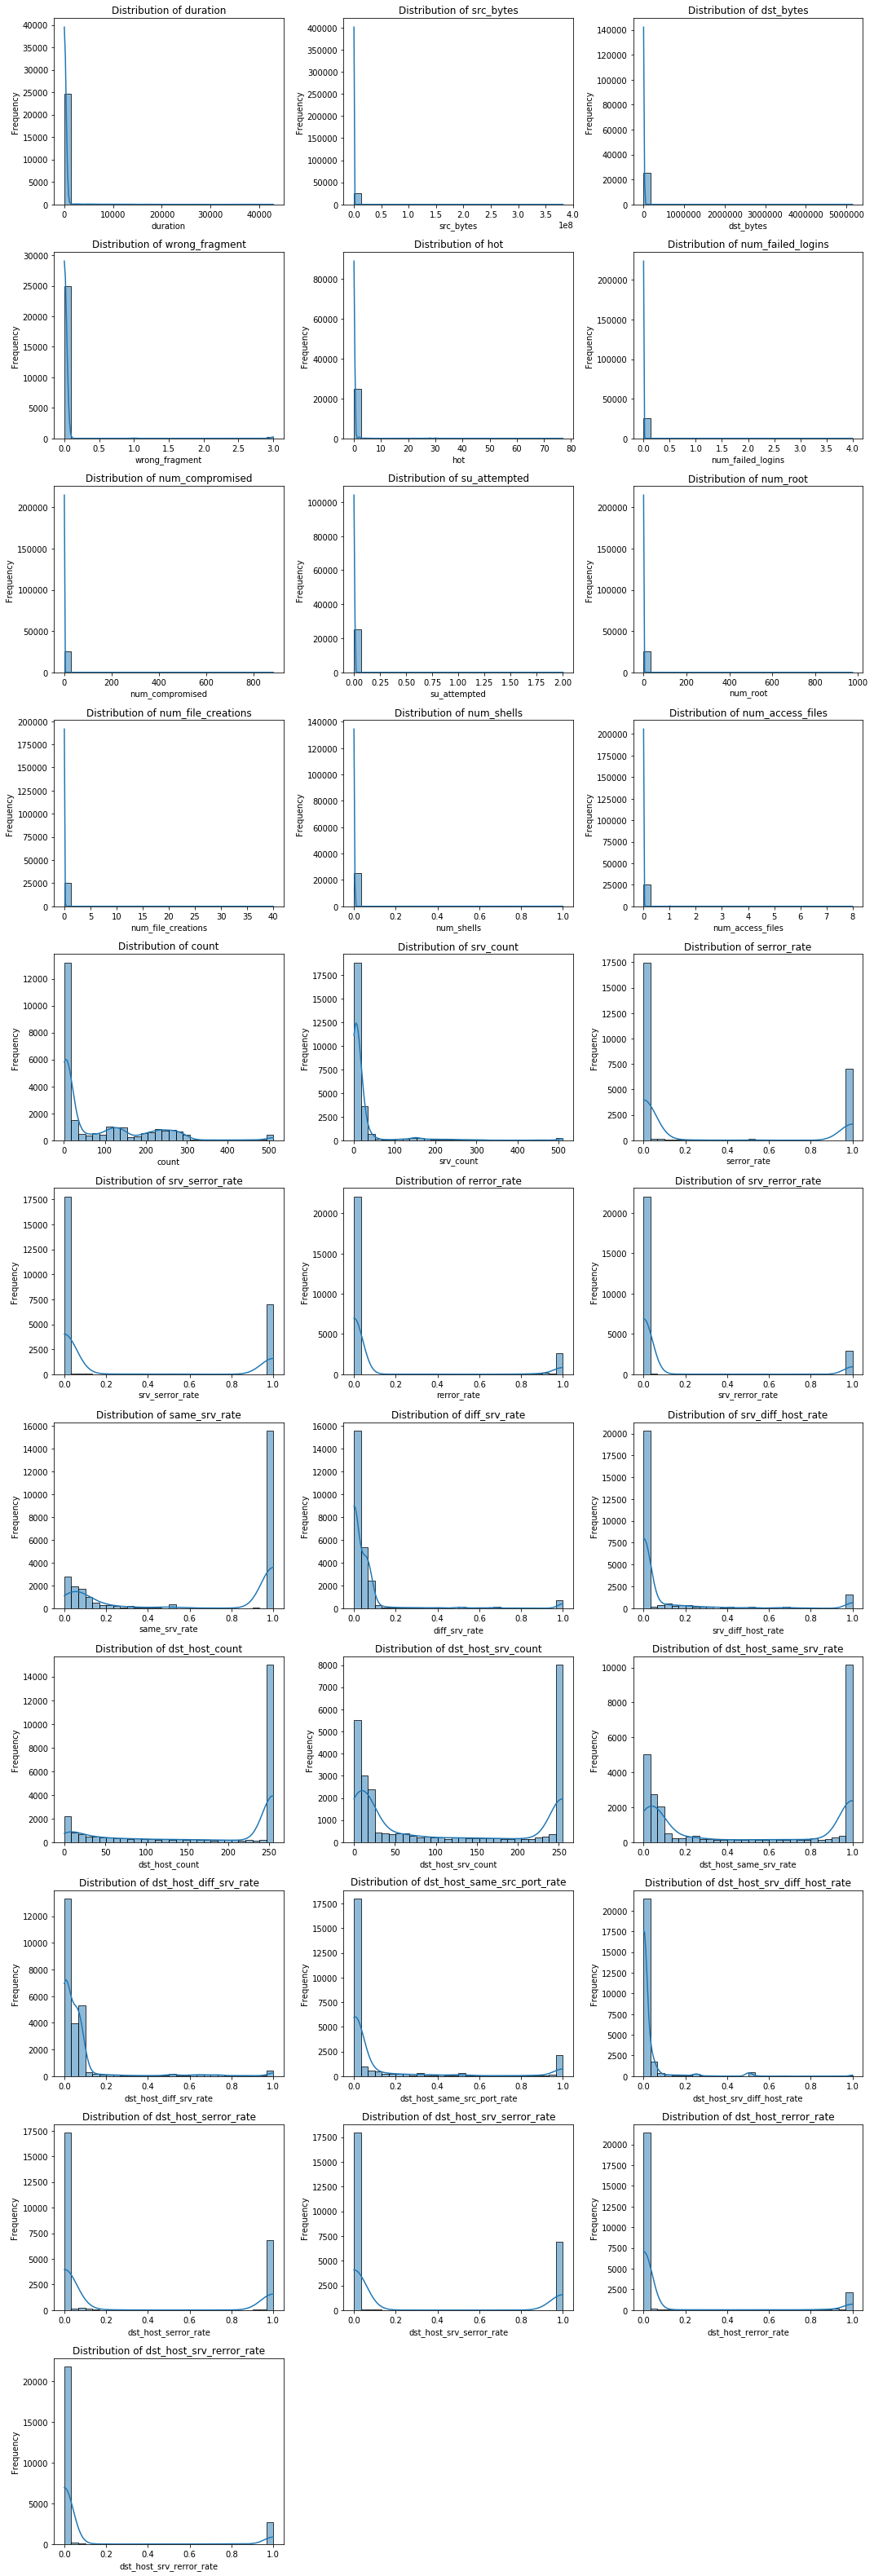

In [70]:
# Determine grid size (e.g., 3 columns)
n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

# Plot each numeric column
for i, col in enumerate(numeric_cols):
    values = data[col].to_numpy()  # ensure it's a NumPy array
    sns.histplot(values, kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
